# Analyzing with datasets and models that are already one-hot encoded

This notebook will perform the same analysis as the [Analyze Feature Usage](../analyze_feature_usage/AnalyzeFeatureUsage.ipynb) notebook, but do so with a dataset (and corresponding model) that is already encoded so that the categorical features are one-hot vectors.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
import tempfile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiFeatureRestriction,
                                      CertifaiFeatureDataType, CertifaiFeatureSchema, CertifaiDataSchema)
from certifai.common.utils.encoding import CatEncoder

In [2]:
# First let's create our one-hot-encoded dataset.  For the purposes of this example we'll generate this from
# the value-encoded dataset we used previously in the Analyze Feature Usage' notebook, but in a real-world example
# we might have been given the dataset already encoded this way.
# As before the example  will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"
all_data_one_hot_file = f"{tempfile.gettempdir()}/german_credit_eval_one_hot.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

X_raw = df.drop(label_column, axis=1)

# Create a DataFrame of the data in the one-hot encoded space
cat_encoder = CatEncoder(cat_columns, X_raw, normalize=False)
df_encoded = pd.DataFrame(cat_encoder(X_raw.values), columns=cat_encoder.transformed_features)
# Add back the outcome
df_encoded[label_column] = df[label_column]
# Restore datatypes of individual numeric columns
for col in X_raw.columns:
    if col not in cat_columns:
        df_encoded[col] = df_encoded[col].astype(X_raw[col].dtype)
        
# Save to an encoded CSV 
df_encoded.to_csv(all_data_one_hot_file, index=False)

# This is what the data looks like after encoding
display(df_encoded)

# We will also want to know how the categorical encoding has mapped categorical values to columns, so
# save this as a dictionary for later use (if the data were given to us pre-encoded then we'd need
# to construct this mapping manually based on manual analysis of the data or a schema definition also given
# to us with the dataset)
cat_value_mappings = {}
for feature in cat_columns:
    value_indexes = cat_encoder.cat_indexes_of_feature(feature)
    # Convert indexes to column names
    cat_value_mappings[feature] = {df_encoded.columns[c_idx]: val for val, c_idx in value_indexes.items()}
    print(f"Feature value -> column mappings for categorical feature '{feature}':")
    for val, col in cat_value_mappings[feature].items():
        print(f"\t{col} -> {val}")


,checkingstatus_... < 0 DM,checkingstatus_... >= 200 DM / salary assignments for at least 1 year,checkingstatus_0 <= ... < 200 DM,checkingstatus_no checking account,duration,history_all credits at this bank paid back duly,history_critical account/ other credits existing (not at this bank),history_delay in paying off in the past,history_existing credits paid back duly till now,history_no credits taken/ all credits paid back duly,...,job_management/ self-employed/highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,liable,telephone_phone - none,"telephone_phone - yes, registered under the customers name",foreign_foreign - no,foreign_foreign - yes,outcome
0,0.00,1.00,0.00,0.00,6,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,2,1.00,0.00,1.00,0.00,1
1,1.00,0.00,0.00,0.00,28,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,1.00,1,1.00,0.00,0.00,1.00,2
2,0.00,0.00,0.00,1.00,24,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,1,0.00,1.00,0.00,1.00,1
3,0.00,0.00,0.00,1.00,24,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,1,0.00,1.00,0.00,1.00,1
4,0.00,0.00,0.00,1.00,12,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,1,0.00,1.00,0.00,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.00,0.00,0.00,0.00,18,1.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1,1.00,0.00,0.00,1.00,2
996,0.00,0.00,0.00,1.00,24,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1,0.00,1.00,0.00,1.00,1
997,0.00,0.00,0.00,1.00,36,0.00,0.00,0.00,1.00,0.00,...,1.00,0.00,0.00,0.00,1,0.00,1.00,0.00,1.00,2
998,0.00,1.00,0.00,0.00,36,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,1,1.00,0.00,0.00,1.00,2


Feature value -> column mappings for categorical feature 'checkingstatus':
	... < 0 DM -> checkingstatus_... < 0 DM
	... >= 200 DM / salary assignments for at least 1 year -> checkingstatus_... >= 200 DM / salary assignments for at least 1 year
	0 <= ... < 200 DM -> checkingstatus_0 <= ... < 200 DM
	no checking account -> checkingstatus_no checking account
Feature value -> column mappings for categorical feature 'history':
	all credits at this bank paid back duly -> history_all credits at this bank paid back duly
	critical account/ other credits existing (not at this bank) -> history_critical account/ other credits existing (not at this bank)
	delay in paying off in the past -> history_delay in paying off in the past
	existing credits paid back duly till now -> history_existing credits paid back duly till now
	no credits taken/ all credits paid back duly -> history_no credits taken/ all credits paid back duly
Feature value -> column mappings for categorical feature 'purpose':
	business

In [3]:
# Load the data - in this case we strictly already have it due to the above cell, but in a pre-encoded
# case we wouldn't so loading from file here is just for the sake of generality
df_encoded = pd.read_csv(all_data_one_hot_file)

# Separate outcome
y = df[label_column]
X = df_encoded.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Now we're in numeric+one-hot space we can just use another encoder to scale everything
# This amounts to the same thing as using `StandardScaler`, but has the correct interface
# for use as a Certifai proxy encoder (it's pickleable and callable)
encoder = CatEncoder([], X)  # No categorical fields to encode this time

# Fit a classification models (note - no train/test split here currently as I'm just using the same data as
# the scan will)
logistic_model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=1000)
logistic_model.fit(encoder(X_train.values), y_train.values)
dtree_model = DecisionTreeClassifier()
dtree_model.fit(encoder(X_train.values), y_train.values)

# Assess on the test set
logistic_accuracy = logistic_model.score(encoder(X_test.values), y_test.values)
print(f"Logistic classifier model accuracy on test data is {logistic_accuracy}")
dtree_accuracy = dtree_model.score(encoder(X_test.values), y_test.values)
print(f"Decision tree model accuracy on test data is {dtree_accuracy}")

Logistic classifier model accuracy on test data is 0.775
Decision tree model accuracy on test data is 0.695


In [4]:
# Wrap the model up for use by Certifai as a local model
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)
dtree_model_proxy = CertifaiPredictorWrapper(dtree_model, encoder=encoder)

In [5]:
# Create a scan to extract counterfactual explanations of the model predictions and build
# a histogram of the feature usage in those counterfactuals

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)
# Add our local models
first_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('dtree',
                            local_predictor=dtree_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_one_hot_file))
scan.add_dataset(eval_dataset)

# Because some fields are one-hot encoded we need to define them in the schema so that
# Certifai knows the value mappings to columns
cat_features = []
for feature in cat_columns:
    data_type = CertifaiFeatureDataType.categorical(value_columns=cat_value_mappings[feature].items())
    feature_schema = CertifaiFeatureSchema(name=feature,
                                           data_type=data_type)
    cat_features.append(feature_schema)
schema = CertifaiDataSchema(features=cat_features)
scan.dataset_schema = schema

# don't allow changes to the nationality status
scan.add_feature_restriction('foreign', CertifaiFeatureRestriction.constant())

# Setup an evaluation for explanation on the above dataset using the model
scan.add_evaluation_type('explanation')
scan.evaluation_dataset_id = 'evaluation'
# For this analysis we'll generate explanations for the entire dataset so we have a good number
# on which to base statistical measures
scan.explanation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: 'f6622e6e4d7a'
[--------------------] 2020-06-03 10:09:55.359339 - 0 of 2 reports (0.0% complete) - Running explanation evaluation for model: logistic
[##########----------] 2020-06-03 10:17:59.420716 - 1 of 2 reports (50.0% complete) - Running explanation evaluation for model: dtree
[####################] 2020-06-03 10:22:51.048708 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [6]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible

# Here we'll extract the frequency of feature usage in generated counterfactuals for each model
def get_feature_frequency(model_id):
    # Extract the information for fairness of a particular model id
    local_model_explanation_info = result['explanation'][model_id]
    # Extract the full set of counterfactuals for this
    all_counterfactuals = [ind for r in local_model_explanation_info['explanations'] for ind in r['bestIndividuals']]

    def features_changed(counterfactual):
        # Each feature has an entry saying how it changed.  This will be one of:
        #   'unchanged'
        #   'changed' (categorical change)
        #   <numeric> (differnce from original value for numeric feaure)
        def no_change(diff):
            return (diff == 'unchanged') or diff == 0

        diffs = counterfactual['diff']
        return [idx for idx in range(len(diffs)) if not no_change(diffs[idx])]


    # Get the full list of model features from the schema
    features = local_model_explanation_info['model_schema']['feature_schemas']
    num_model_features = len(features)

    feature_names = np.array([f['name'] for f in features])
    
    # Count the changes for each feature across the dataset
    all_changes = np.zeros(num_model_features)
    for cf in all_counterfactuals:
        changed = features_changed(cf)
        for idx in changed:
            all_changes[idx] += 1
    return all_changes, feature_names

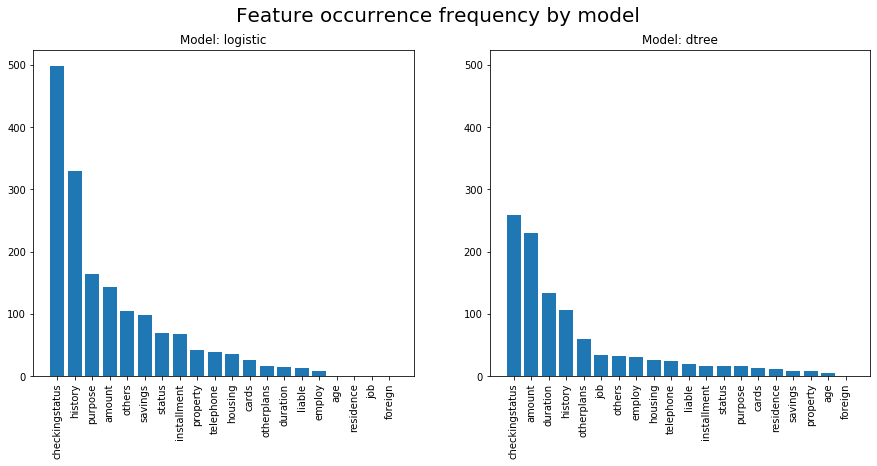

In [7]:
# Plot a histogram of frequency of occurrence of changes to each feature in counterfactuals
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(ax, model_id):
    all_changes, feature_names = get_feature_frequency(model_id)
    indexes = np.arange(len(all_changes))
    order = np.argsort(-all_changes)

    ax.bar(indexes,all_changes[order])

    ax.ylabel = 'Frequency'
    ax.set_title(f'Model: {model_id}')
    ax.set_xticks(indexes)
    ax.set_xticklabels(feature_names[order], rotation=90)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
fig.suptitle('Feature occurrence frequency by model', fontsize=20)

plot_histogram(ax1, 'logistic')
plot_histogram(ax2, 'dtree')

# Put them both on the same scale
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)

plt.show()